In [2]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import shap
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay



Import and perform some data preporcessing

In [4]:
class DataBase:
    def __init__(self):
        self.__load_data()

    def __load_data(self):
        self.WaterQuality = pd.read_csv('waterQuality.csv') # Import your DATA <=====
        self.X = self.WaterQuality.iloc[:, :-1]
        self.y = self.WaterQuality.iloc[:, -1]
        self.co = 0
        self.cm = 0

    def check_missing_values(self, remove=False):
        if remove:
            missing_indices = self.X[self.X.isna().any(axis=1)].index
            self.X.drop(index=missing_indices, inplace=True)
            self.y.drop(index=missing_indices, inplace=True)
            self.X.reset_index(drop=True, inplace=True)
            self.y.reset_index(drop=True, inplace=True)
        else:
            missing_data = self.X.isna().sum()
            if missing_data.any():
                print('\nMissing data:')
                print(missing_data[missing_data > 0])
            else:
                print('\nNo missing data in dataset')

    def check_duplicated_rows(self, remove=False):
        if remove:
            self.X.drop_duplicates(keep=False, inplace=True)
            #print(f'Duplicate rows removed from {name}')
        else:
            duplicates = self.X.duplicated(keep=False)
            if duplicates.any():
                print(f'\nThere are {duplicates.sum()} duplicate rows in dataset at indices:')
                print(self.X[duplicates].index.tolist())
            else:
                print('\nNo duplicate rows in dataset')

    def check_duplicated_columns(self, remove=False):
        if remove:
            self.X = self.X.T.drop_duplicates(keep='first')
            self.X = self.X.T
            #print(f'Duplicates columns removed from {name}')
        else:
            duplicates = self.X.T.duplicated(keep=False).T
            if duplicates.any():
                print(f'\nThere are {duplicates.sum()} duplicate rows in dataset at indices:')
                print(self.X[duplicates].index.tolist())
            else:
                print('\nNo duplicate columns in dataset')

    def histbox_plot(self, col_index = 0, bins = 'auto'):

        self.check_missing_values(True)
        self.check_duplicated_rows(True)
        self.check_duplicated_columns(True)

        if self.co == 0:
            self.__remove_outliers()

        fig, axes = plt.subplots(1, 2)

        sns.histplot(self.X.iloc[:, col_index], bins=bins, ax=axes[0])
        axes[0].set_title('Histogram of ' + self.X.columns[col_index])

        sns.boxenplot(y=self.X.iloc[:, col_index], ax=axes[1])
        axes[1].set_title('Boxenplot of ' + self.X.columns[col_index])
        plt.show()

    def var_relation_plot(self):

        self.check_missing_values(True)
        self.check_duplicated_rows(True)
        self.check_duplicated_columns(True)

        corr = self.X.corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('Correlation Heatmap for Numerical Features')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def __remove_outliers(self):
        Q1 = self.X.quantile(0.25)
        Q3 = self.X.quantile(0.75)
        IQR = Q3 - Q1
        lb = Q1 - 1.5 * IQR
        ub = Q1 + 1.5 * IQR
        self.X = self.X.clip(lower=lb, upper=ub, axis=1)
        #print('\nOutliers are removed!')
        self.co = 1

    def prep_data(self, outlier = False, scale = False):
        self.check_missing_values(True)
        self.check_duplicated_rows(True)
        self.check_duplicated_columns(True)

        if outlier and (self.co == 0):
            self.__remove_outliers()
        if scale and (self.cm == 0):
            scaler = MinMaxScaler()
            self.X = pd.DataFrame(scaler.fit_transform(self.X), columns=self.X.columns)
            self.cm = 1
            #print('\nMin and Max scaling is applied!')

        Features = self.X
        Targets = self.y.str.lower().map({'yes': 1, 'no': 0, 'unknown': 0})
        Targets.values.ravel()

        return Features, Targets

    def TrainTest(self, X, y, tsize = 0.3):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize, random_state=33)

        return X_train, X_test, y_train, y_test

Define the important features

In [5]:
class ImpFeature:
    def __init__(self, X, y):
        self.X = X
        self.y = y.values.ravel()
        self.vote = []
        self.accuracies = {}
        self.__run_all()

    def __rf(self):
        rf = RandomForestClassifier(random_state=42)
        rf.fit(self.X, self.y)
        importances = rf.feature_importances_
        feature_names = self.X.columns
        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        self.vote.append(feature_importances.index.values)
        self.accuracies['Random Forest'] = accuracy_score(self.y, rf.predict(self.X))

    def __svm(self):
        svm = LinearSVC(random_state=42, dual=True)
        svm.fit(self.X, self.y)
        importances = abs(svm.coef_).mean(axis=0)
        feature_names = self.X.columns
        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        self.vote.append(feature_importances.index.values)
        self.accuracies['Linear SVM'] = accuracy_score(self.y, svm.predict(self.X))


    def __gb(self):
        gb = GradientBoostingClassifier(random_state=42)
        gb.fit(self.X, self.y)
        importances = gb.feature_importances_
        feature_names = self.X.columns
        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        self.vote.append(feature_importances.index.values)
        self.accuracies['Gradient Boosting'] = accuracy_score(self.y, gb.predict(self.X))

    def __lr(self):
        lr = LogisticRegression(solver='lbfgs', random_state=42)
        lr.fit(self.X, self.y)
        importances = abs(lr.coef_).mean(axis=0)
        feature_names = self.X.columns
        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        self.vote.append(feature_importances.index.values)
        self.accuracies['Logistic Regression'] = accuracy_score(self.y, lr.predict(self.X))

    def __knn(self):
        knn = KNeighborsClassifier()
        knn.fit(self.X.values, self.y)
        result = permutation_importance(knn, self.X.values, self.y, n_repeats=20, random_state=42, n_jobs=-1)
        importances = result.importances_mean
        feature_names = self.X.columns
        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        self.vote.append(feature_importances.index.values)
        self.accuracies['KNN'] = accuracy_score(self.y, knn.predict(self.X.values))

    def __mlp(self):
        mlp = MLPClassifier(random_state=42)
        mlp.fit(self.X.values, self.y)
        result = permutation_importance(mlp, self.X.values, self.y, n_repeats=20, random_state=42, n_jobs=-1)
        importances = result.importances_mean
        feature_names = self.X.columns
        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        self.vote.append(feature_importances.index.values)
        self.accuracies['MLP'] = accuracy_score(self.y, mlp.predict(self.X))

    def find_repetitive_ind(self):
        repetitive_ind = []
        feature_names = []
        xin = np.vstack(self.vote).T
        for row in xin:
            counter = Counter(row)
            row_repeats = [item for item, count in counter.items() if count > 1]
            repetitive_ind.append(row_repeats)
            feature_names.append([self.X.columns[item] for item in row_repeats])

        for i in range(len(feature_names)):
            print(f'rank {i+1}: {feature_names[i]}')

    def __run_all(self):
        self.__rf()
        self.__svm()
        self.__gb()
        self.__lr()
        self.__knn()
        self.__mlp()

    def shap_analysis(self):
        svm = LinearSVC(random_state=42, dual=False)
        svm.fit(self.X, self.y)

        small_X = self.X.sample(100, random_state=42)  # Random sample of 100 rows

        explainer = shap.KernelExplainer(svm.predict, small_X)
        shap_values = explainer.shap_values(self.X)

        shap.summary_plot(shap_values, self.X, feature_names=self.X.columns)

Build Classifiers

In [27]:
class NeuralNetWorkModels:
    def __init__(self, X_train, X_test, y_train, y_test, epochs = 100, batch_size = 5, val_split = 0.2, h = 50):

        self.X_train, self.X_test, self.y_train, self.y_test = X_train.values, X_test.values, y_train, y_test
        self.val_split = val_split
        self.batch_size = batch_size
        self.epochs = epochs
        self.h = h

        self.X_train_cnn = self.X_train.reshape((self.X_train.shape[0], self.X_train.shape[1], 1))
        self.X_test_cnn = self.X_test.reshape((self.X_test.shape[0], self.X_test.shape[1], 1))

    def build_and_train_mlp(self):

        self.mlp_model = Sequential([
            Dense(self.h, activation='relu', input_shape=(self.X_train.shape[1],)),
            Dense(self.h, activation='relu'),
            Dense(2, activation='softmax')])

        self.mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.mlp_model.fit(self.X_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size, validation_split=self.val_split)



    def evaluate_mlp(self):
        mlp_loss, mlp_accuracy = self.mlp_model.evaluate(self.X_test, self.y_test)
        print(f'MLP Accuracy: {mlp_accuracy}')
        return mlp_accuracy



class ClassicalML:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

    def random_forest(self):
        rf = RandomForestClassifier(random_state=42)
        rf.fit(self.X_train, self.y_train)
        yt_pred = rf.predict(self.X_train)
        ys_pred = rf.predict(self.X_test)
        tr_accu = accuracy_score(self.y_train, yt_pred)
        ts_accu = accuracy_score(self.y_test, ys_pred)
        print(f'Random Forest Train Accuracy: {tr_accu}, Test Accuracy: {ts_accu}')
        cm = confusion_matrix(y_test, ys_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()


    def logistic_regression(self):
        lr = LogisticRegression(solver='lbfgs', random_state=42)
        lr.fit(self.X_train, self.y_train)
        yt_pred = lr.predict(self.X_train)
        ys_pred = lr.predict(self.X_test)
        tr_accu = accuracy_score(self.y_train, yt_pred)
        ts_accu = accuracy_score(self.y_test, ys_pred)
        print(f'Logistic Regression Train Accuracy: {tr_accu}, Test Accuracy: {ts_accu}')
        cm = confusion_matrix(y_test, ys_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    def svm(self):
        svm = SVC(kernel='linear', decision_function_shape='ovr', random_state=42)
        svm.fit(self.X_train, self.y_train)
        yt_pred = svm.predict(self.X_train)
        ys_pred = svm.predict(self.X_test)
        tr_accu = accuracy_score(self.y_train, yt_pred)
        ts_accu = accuracy_score(self.y_test, ys_pred)
        print(f'SVM Train Accuracy: {tr_accu}, Test Accuracy: {ts_accu}')
        cm = confusion_matrix(y_test, ys_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    def gradient_boosting(self):
        gb = GradientBoostingClassifier(random_state=42)
        gb.fit(self.X_train, self.y_train)
        yt_pred = gb.predict(self.X_train)
        ys_pred = gb.predict(self.X_test)
        tr_accu = accuracy_score(self.y_train, yt_pred)
        ts_accu = accuracy_score(self.y_test, ys_pred)
        print(f'Gradient Boosting Train Accuracy: {tr_accu}, Test Accuracy: {ts_accu}')
        cm = confusion_matrix(y_test, ys_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Load the data

In [35]:
Data = DataBase()

Describe the unprocessed data

In [36]:
print(Data.X.info())
print('\n\n\n')
print(Data.X.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8499 entries, 0 to 8498
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    8479 non-null   float64
 1   ammonia      8473 non-null   float64
 2   arsenic      8487 non-null   float64
 3   barium       8486 non-null   float64
 4   cadmium      8480 non-null   float64
 5   chloramine   8480 non-null   float64
 6   chromium     8485 non-null   float64
 7   copper       8488 non-null   float64
 8   flouride     8487 non-null   float64
 9   bacteria     8491 non-null   float64
 10  viruses      8480 non-null   float64
 11  lead         8490 non-null   float64
 12  nitrates     8489 non-null   float64
 13  nitrites     8490 non-null   float64
 14  mercury      8482 non-null   float64
 15  perchlorate  8489 non-null   float64
 16  radium       8490 non-null   float64
 17  selenium     8490 non-null   float64
 18  silver       8485 non-null   float64
 19  uraniu

Check the missing values. If "remove" is set to "True", it removes the missing values. The default value is "False".

In [37]:
Data.check_missing_values(remove = False)


Missing data:
aluminium      20
ammonia        26
arsenic        12
barium         13
cadmium        19
chloramine     19
chromium       14
copper         11
flouride       12
bacteria        8
viruses        19
lead            9
nitrates       10
nitrites        9
mercury        17
perchlorate    10
radium          9
selenium        9
silver         14
uranium        10
dtype: int64


Check for duplicated rows and columns in the dataset. If "remove" is set to "True", it removes the duplicated rows and columns.

In [38]:
Data.check_duplicated_rows(remove = False)
Data.check_duplicated_columns(remove = False)


No duplicate rows in dataset

No duplicate columns in dataset


 Plot the histogram and boxplot of numerical features (columns). "bins" defines the number of bins for the histogram, with the default set to "auto". "col_index" is the column index. it shold be a number between 0 to 19 (default value for "col_index" is 0).
 The outlies are removed befor histogram and boxplot ploting

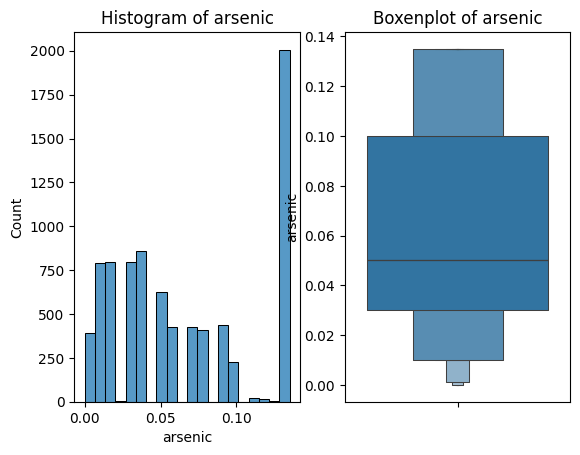

In [39]:
col_index = 2 # choose between 0 to 19
Data.histbox_plot(col_index, bins = 'auto')

Plot the feature correlations.

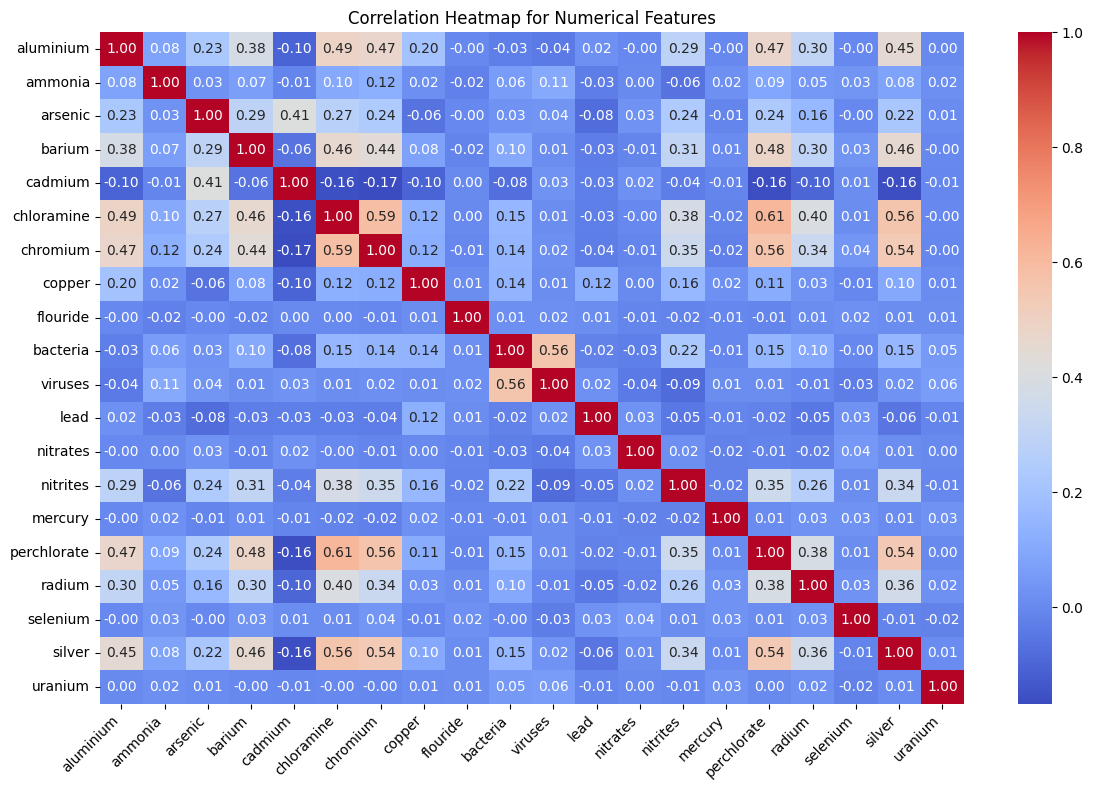

In [40]:
Data.var_relation_plot()

Prepare the X (features) and y (labels). If outlier is set to "True", it removes the outliers, and if scale is set to "True", it scales the features.

In [41]:
X, y = Data.prep_data(outlier = True, scale = True)

More explanation

In [42]:
print(f'Features (columns) name:\n{X.columns}')
print('\n\n\n')
print(f'X dimensions\nnumber of rows: {X.shape[0]}\nnumber of columns: {X.shape[1]}')

Features (columns) name:
Index(['aluminium', 'ammonia', 'arsenic', 'barium', 'cadmium', 'chloramine',
       'chromium', 'copper', 'flouride', 'bacteria', 'viruses', 'lead',
       'nitrates', 'nitrites', 'mercury', 'perchlorate', 'radium', 'selenium',
       'silver', 'uranium'],
      dtype='object')




X dimensions
number of rows: 8229
number of columns: 20


Show the importance of each feature based on their ranks. Feature importance is determined by voting across the outputs of six classifiers, including Random Forest, Support Vector Machine (SVM), Gradient Boosting, Logistic Regression, K-Nearest Neighbors (KNN), and Multi-layer Perceptron (MLP). The ranking is calculated based on feature importance scores generated by each classifier.


In [43]:
features = ImpFeature(X, y)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Show the rank of each features based on the voting strategy over the six classifires.

In [44]:
features.find_repetitive_ind()

rank 1: ['aluminium']
rank 2: ['perchlorate', 'arsenic']
rank 3: ['bacteria', 'perchlorate']
rank 4: ['arsenic', 'perchlorate']
rank 5: ['silver', 'cadmium']
rank 6: ['ammonia']
rank 7: ['ammonia']
rank 8: ['viruses']
rank 9: ['nitrites', 'uranium']
rank 10: ['viruses', 'copper']
rank 11: []
rank 12: ['nitrates']
rank 13: []
rank 14: ['chromium', 'copper']
rank 15: ['radium', 'mercury']
rank 16: ['mercury', 'lead']
rank 17: ['barium', 'lead']
rank 18: ['flouride', 'selenium']
rank 19: ['selenium', 'barium']
rank 20: ['mercury', 'flouride']


Show the rank of each features regarding the classifire algorithm

In [45]:
name = ['rf', 'svm', 'gb', 'lr', 'knn', 'mlp']
for i in range(len(features.vote)):
  print(f'{name[i]} = {features.vote[i]}')

rf = [ 0 15  4  2 18  1  5 12 13 10 19 16  6  9 11  7  3  8 17 14]
svm = [ 0  2  9 15  4 18  1 10 19  7 13  5 12  6 16 14 11 17  3  8]
gb = [ 0  4 15  2 18 19  1 13  5 10  9 12 16  7 14 11  3  6 17  8]
lr = [ 0  2  9 15  4  1 19 10 13  7 18 12  5  6 16 14 11 17  3  8]
knn = [ 0  2 15  4 18 12 10  1 19 13  5  3 11 17  9 16  6  8  7 14]
mlp = [ 0 15  2  5 18  4  1 19  6 12 16 10 13  7 14 11 17  8  3  9]


Analyze and rank the most important features using SHAP values.

  0%|          | 0/8229 [00:00<?, ?it/s]

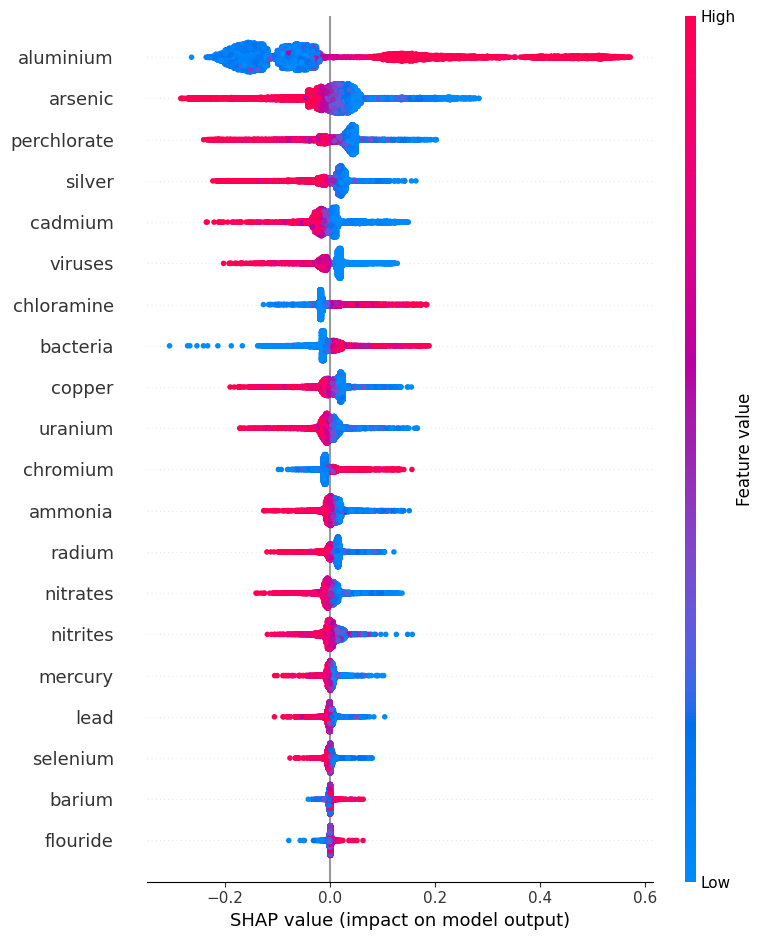

In [54]:
features.shap_analysis()

In [46]:
X_train,X_test, y_train, y_test=Data.TrainTest(X,y,tsize=0.3)

Build the models for MLP

In [47]:
Network = NeuralNetWorkModels(X_train, X_test, y_train, y_test)


Train and Evaluate the MLP

In [48]:
Network.build_and_train_mlp()
accu = Network.evaluate_mlp()

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


922/922 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8773 - loss: 0.3211 - val_accuracy: 0.9193 - val_loss: 0.2554
Epoch 2/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9181 - loss: 0.2290 - val_accuracy: 0.9123 - val_loss: 0.2415
Epoch 3/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9140 - loss: 0.2188 - val_accuracy: 0.9158 - val_loss: 0.2189
Epoch 4/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9272 - loss: 0.1838 - val_accuracy: 0.9297 - val_loss: 0.1977
Epoch 5/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9255 - loss: 0.1932 - val_accuracy: 0.9306 - val_loss: 0.1981
Epoch 6/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9375 - loss: 0.1621 - val_accuracy: 0.9314 - val_loss: 0.2174
Epoch 7/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9387 - loss: 0.1641 - val_accuracy: 0.9219 - val_loss: 0.2271
Epoch 8/100
922/922 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9372 - loss: 0.1731 - val_accuracy: 0.9384

Build the base model for classical ML models, including RF, LR, SVM, and GB.

In [49]:
ML = ClassicalML(X_train, X_test, y_train, y_test)

RF Output

Random Forest Train Accuracy: 1.0, Test Accuracy: 0.9518023491292021


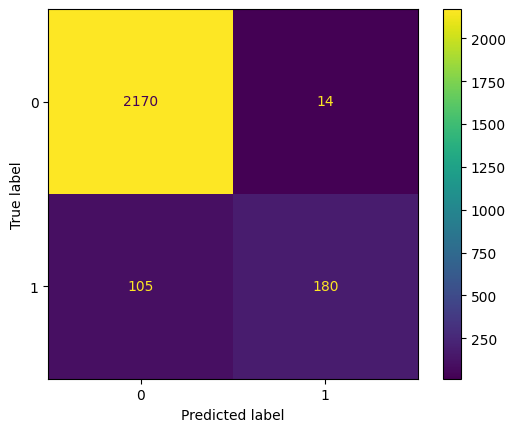

In [50]:
ML.random_forest()

GB Output

Gradient Boosting Train Accuracy: 0.9571180555555555, Test Accuracy: 0.9509923045767518


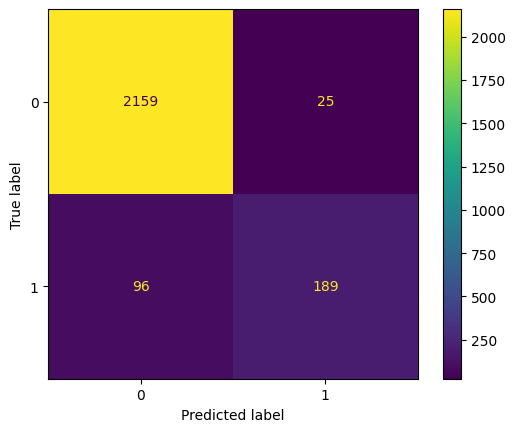

In [51]:
ML.gradient_boosting()

LR Output

SVM Train Accuracy: 0.9170138888888889, Test Accuracy: 0.9210206561360875


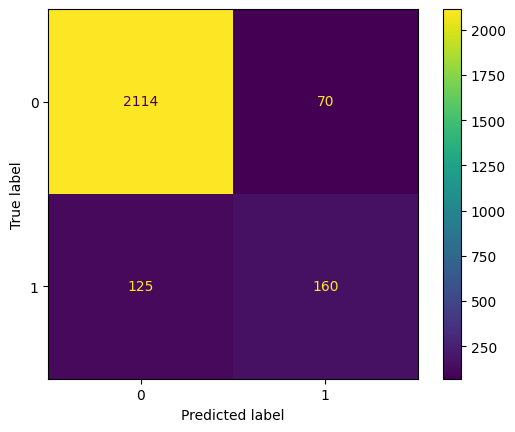

In [52]:
ML.svm()

Logistic Regression Train Accuracy: 0.9159722222222222, Test Accuracy: 0.9202106115836372


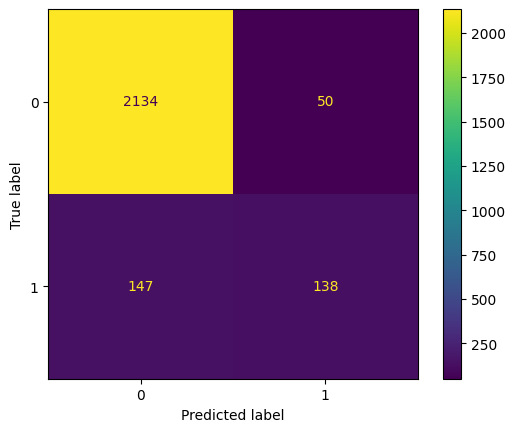

In [53]:
ML.logistic_regression()